In [3]:
#import midi_functions
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten, Softmax
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras import optimizers

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
input_length = 50
X_orig = np.loadtxt('notes/50clementiX.txt')
Y_orig = np.loadtxt('notes/50clementiY.txt')
#sorted_notes = np.loadtxt('notes/norm_sorted_notes.txt')
sorted_notes = np.unique(Y_orig)
n = X_orig.shape[0]
Y = np.copy(Y_orig)
max_note = np.max(Y)
min_note = np.min(Y)

X = X_orig / max_note #normalize input
n_notes_Y = n_hidden_units = len(sorted_notes)

for i,note in enumerate(Y): #make all the notes a number between 0 and number_of_different_notes
    Y[i] = np.where(sorted_notes == note)[0]
Y = np_utils.to_categorical(Y)

print('X={}, Y={}'.format(len(np.unique(X)),n_notes_Y))
print('Shape of X: {}'.format(X.shape))
print('Max: {}, Min: {}'.format(max_note, min_note))

X=38, Y=38
Shape of X: (9613, 10)
Max: 89.0, Min: 50.0


In [18]:
model = Sequential()
model.add(Dense(n_hidden_units, input_shape=((input_length,))))
          
model.add(Activation('softmax'))

rmsprop = optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 38)                418       
_________________________________________________________________
activation_2 (Activation)    (None, 38)                0         
Total params: 418
Trainable params: 418
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
#Remember to change the name of the log file
class live_plot(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.index = 0
        self.epochs = []
        
        self.losses = []
        self.val_losses = []
        
        self.acc = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.epochs.append(self.index)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs['val_acc'])
        self.index += 1
        
        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
        plt.plot(self.epochs, self.acc, label="acc")
        plt.plot(self.epochs, self.val_acc, label="val_acc")
        plt.legend()
        plt.show();
        
class dump_to_file(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        with open('logs/normalized_log.txt','wb') as f:
            np.savetxt(f,np.array([logs.get('loss'),logs.get('val_loss'),logs.get('acc'),logs.get('val_acc')]))

In [15]:
X.shape

(9613, 10)

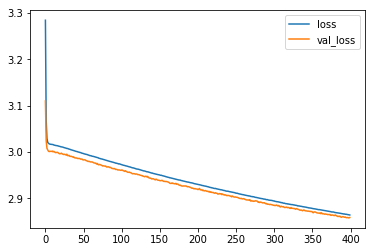

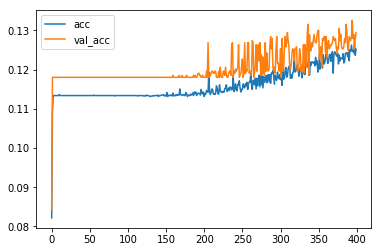

In [21]:
filepath = "./weights/softmax/{epoch:02d}.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

plot = live_plot()
dump = dump_to_file()

callbacks_list = [checkpoint, plot, dump]     
fit_data = model.fit(X.reshape(n, input_length), Y, validation_split=0.20,epochs=400, batch_size=64, callbacks=callbacks_list)

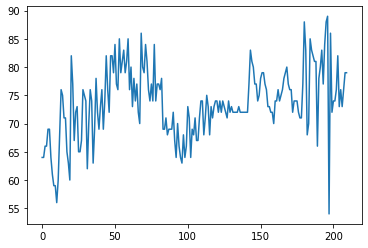

In [11]:
#Generate 200 notes
#model.load_weights('./hijacked_weights/hijacked-125.hdf5')
#random sequence to initialize predictions
init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(200 + input_length)
predicted_notes[0:input_length] = init

for note_index in range(200):
    x = predicted_notes[note_index:note_index + input_length]
    prediction = model.predict(x.reshape(1,input_length,1))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
predicted_notes = predicted_notes * max_note
plt.plot(predicted_notes)

In [12]:
predicted_notes

array([64., 64., 66., 66., 69., 69., 64., 61., 59., 59., 56., 60., 68.,
       76., 75., 71., 71., 65., 63., 60., 82., 77., 67., 72., 73., 65.,
       65., 67., 76., 75., 74., 62., 70., 76., 74., 63., 69., 78., 72.,
       69., 73., 76., 69., 74., 82., 76., 72., 82., 82., 79., 84., 77.,
       76., 85., 79., 81., 83., 79., 81., 85., 76., 80., 73., 78., 74.,
       77., 72., 70., 86., 80., 79., 84., 81., 76., 74., 77., 74., 84.,
       74., 77., 77., 76., 78., 69., 69., 71., 68., 69., 69., 69., 72.,
       67., 64., 70., 66., 64., 63., 68., 64., 66., 73., 71., 64., 69.,
       68., 71., 67., 67., 71., 74., 74., 68., 71., 75., 73., 68., 73.,
       71., 73., 74., 74., 72., 74., 72., 74., 73., 72., 71., 74., 72.,
       73., 72., 72., 72., 72., 73., 72., 72., 72., 72., 72., 72., 77.,
       83., 81., 80., 77., 77., 74., 75., 78., 79., 79., 77., 76., 73.,
       73., 72., 72., 70., 74., 74., 76., 74., 75., 76., 78., 79., 80.,
       77., 76., 76., 72., 74., 74., 74., 72., 71., 71., 77., 88

In [7]:
midi_functions.create_midi_from_notes(predicted_notes, on=250)